In [4]:
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from py import util

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = '../data/01_processed'

In [5]:
tracking = pd.read_parquet(join(DATA_DIR, 'tracking.parquet'))
plays = pd.read_parquet(join(DATA_DIR, 'plays.parquet'))
games = pd.read_parquet(join(DATA_DIR, 'games.parquet'))
player_play = pd.read_parquet(join(DATA_DIR, 'player_play.parquet'))

# 5. Aggregate field control within RB vision cone
Apply this over the frames until the rb passes beyond the oline influence, to quantify how much space the rb has to run through. One possible limitation to this approach is rb skill will also likely lead to more open space, due to better vision, speed, or agility.

#### Calculate the euclidean distance from the ball carrier to each player for each frame 

In [22]:
rb_coords = (
    tracking[tracking['is_ball_carrier'] == 1]
    .set_index(['game_play_id', 'frame_id'])[['x', 'y']]
    .rename(columns={'x': 'ball_carrier_x', 'y': 'ball_carrier_y'})
)

tracking = tracking.merge(
    rb_coords,
    left_on=['game_play_id', 'frame_id'],
    right_index=True,
    how='left'
)

tracking['euclidean_dist_to_ball_carrier'] = (
    ((tracking['x'] - tracking['ball_carrier_x']) ** 2 +
     (tracking['y'] - tracking['ball_carrier_y']) ** 2) ** 0.5
).round(2)

tracking.drop(columns=['ball_carrier_x', 'ball_carrier_y'], inplace=True)

#### Find the closest offensive player to each defender. Mark the defender as engaged if they are within 1.5 feet of the offensive player

In [23]:
defenders = tracking[(tracking['offense'] == 0) & (tracking['club'] != 'football')].copy()
offense = tracking[(tracking['offense'] == 1) & (tracking['club'] != 'football')].copy()

defenders = defenders.rename(columns={'nfl_id': 'def_nfl_id', 'x': 'def_x', 'y': 'def_y'})
offense = offense.rename(columns={'nfl_id': 'off_nfl_id', 'x': 'off_x', 'y': 'off_y'})

merged = defenders.merge(
    offense[['game_play_id', 'frame_id', 'off_nfl_id', 'off_x', 'off_y']],
    on=['game_play_id', 'frame_id'],
    how='left'
)

merged['dist'] = np.sqrt((merged['def_x'] - merged['off_x'])**2 + (merged['def_y'] - merged['off_y'])**2)

merged = merged.sort_values(['game_play_id', 'frame_id', 'def_nfl_id', 'dist'])

# Get closest offensive player to each defender
closest = merged.loc[
    merged.groupby(['game_play_id', 'frame_id', 'def_nfl_id'])['dist'].idxmin(),
    ['game_play_id', 'frame_id', 'def_nfl_id', 'def_x', 'def_y', 
     'off_nfl_id', 'off_x', 'off_y', 'dist']
].copy()

# Rename columns
closest = closest.rename(columns={
    'off_x': 'x_closest_off_player',
    'off_y': 'y_closest_off_player',
    'off_nfl_id': 'closest_off_nfl_id',
    'dist': 'closest_off_dist'
})

# Mark engagement (1.5 feet = 0.5 yards)
closest['engaged'] = closest['closest_off_dist'] < 0.5

# Merge back to original tracking data
tracking = tracking.merge(
    closest[['game_play_id', 'frame_id', 'def_nfl_id', 'x_closest_off_player', 'y_closest_off_player', 'engaged']],
    left_on=['game_play_id', 'frame_id', 'nfl_id'],
    right_on=['game_play_id', 'frame_id', 'def_nfl_id'],
    how='left'
).drop(columns=['def_nfl_id'])

tracking['engaged'] = tracking['engaged'].fillna(False).astype(bool)

#### Field Control functions

In [37]:
def influence(
        p: np.ndarray,
        p_i: np.ndarray,
        s: float,
        theta: float,
        rb_dist: float,
        is_offense: bool,
    ):
    '''
    Calculate the influence of a player on a point in the field.

    Args:
        p: coordinates of the point in the field.
        p_i: coordinates of the player.
        s: speed of the player.
        theta: direction of the player in radians.
        rb_dist: distance to the ball carrier.
        is_offense: boolean indicating if the player is on offense.
    Returns:    
        Influence value at the point.
    '''
    influence = (
        _bivariate_gaussian_pdf(p, p_i, s, theta, rb_dist) /
        _bivariate_gaussian_pdf(p_i, p_i, s, theta, rb_dist)
    )

    if is_offense:
        return influence
    return -influence

def _piecewise_function(x):
    """ Function reduces influence area radius if a player is closer to the rb """
    if x <= 18:
        return 0.01854*x**2 + 4  # Parabola for x <= 18
    else:
        return 10  # Flat line at y = 10 for x > 18

def _rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def _speed_ratio(s):
    return s**2 / 13**2
    
def _scaling_matrix(rb_dist, s):
    R = _piecewise_function(rb_dist)
    s_ratio = _speed_ratio(s)
    s_x = (R + (R * s_ratio)) / 2
    s_y = (R - (R * s_ratio)) / 2
    return np.array([[s_x,0],[0,s_y]])

def _mu(p_i, s_vect):
    s_unit_vector = s_vect / np.linalg.norm(s_vect)
    return p_i + (.5 * s_unit_vector)

def _cov(theta, rb_dist, s):
    S = _scaling_matrix(rb_dist, s)
    R = _rotation_matrix(theta)
    return R @ S @ S @ np.linalg.inv(R)

def _bivariate_gaussian_pdf(
    p: np.ndarray,
    p_i: np.ndarray,
    s: float,
    theta: float,
    rb_dist: float
):
    """
    Calculate the bivariate Gaussian PDF for a point in the field.
    
    Args:
        p: coordinates of the point in the field (2D vector).
        p_i: coordinates of the player (2D vector).
        s: player speed (float).
        theta: direction of motion in radians.
        rb_dist: Euclidean distance to the ball carrier.
        
    Returns:
        Float: PDF value at point p.
    """
    s_x = s * np.cos(theta)
    s_y = s * np.sin(theta)
    s_vect = np.array([s_x, s_y])
    
    mu = _mu(p_i, s_vect)
    sigma = _cov(theta, rb_dist, s)
    
    diff = p - mu
    constant = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))
    exponent = -0.5 * diff.T @ np.linalg.inv(sigma) @ diff
    return constant * np.exp(exponent)

#### Visualize the field control within the ball carriers vision cone. This is filtered down to the frames of a play where the oline blocking has the greatest effect

In [40]:
plays.query('game_play_id == "2022091104_1917"').play_description.values[0]

'(4:34) D.Swift left tackle to PHI 29 for 13 yards (M.Epps).'

In [50]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys

game_play_id = '2022091104_1917'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
yardline = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = 1
xmin, xmax = 0, 53.3

fig, ax = plt.subplots(figsize=(10, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                scale = 1
                if row.engaged:
                    # angle formed from defender to closest offensive player to the point
                    # the scale is (180 - angle) / 180
                    defender_pos = np.array([row.x, row.y])
                    off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                    point_pos = np.array(coord)
                    vec_def_to_off = off_player_pos - defender_pos
                    vec_point_to_off = off_player_pos - point_pos
                    angle = np.degrees(np.arccos(
                        np.dot(vec_def_to_off, vec_point_to_off) /
                        (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                    ))
                
                    # Scale factor ranges from 0 (180°) to 1 (0°) to the square root of the scale (make it more gradual)
                    scale = ((180 - angle) / 180) ** .5
                    scale = np.clip(scale, 0, 1)
                    
                field_control[i, j] += scale * influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))  # sigmoid normalization

def get_vision_cone(rb_pos, rb_dir_rad, rb_speed, cone_angle_deg=45, min_length=3, speed_factor=0.3):
    """
    Returns properly angled semi-elliptical cone with correct width
    - cone_angle_deg: Total angular width (now correctly 45 degrees)
    - min_length: minimum cone length in yards
    - speed_factor: how much speed affects cone length
    """
    cone_length = min_length + rb_speed * speed_factor
    
    # Create points for the curved front (semi-ellipse)
    t = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), 20)
    ellipse_x = cone_length * np.cos(t)
    ellipse_y = cone_length * np.sin(t) * 0.7
    
    points = np.column_stack([np.concatenate([[0], ellipse_x]),
                             np.concatenate([[0], ellipse_y])])
    
    # Rotate to face RB direction
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                          [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ points.T).T
    
    # Translate to field position
    return rotated_points + rb_pos

def calculate_cone_field_control(fc, coords, cone_vertices):
    """Improved version using path contains_points"""
    from matplotlib.path import Path
    path = Path(cone_vertices)
    mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
    return fc[mask].mean() if np.any(mask) else 0

X_global, Y_global, coords_global = create_mesh(df_all)

cone_stats = {'frame_values': [], 'average': 0}

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]
    
    ymin, ymax = frame_df['y'].min() - 1, frame_df['y'].max() + 1
    X, Y, coords = create_mesh(frame_df)
    fc = compute_field_control(frame_df, coords)
    
    ax.imshow(fc, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='coolwarm', alpha=0.5, aspect='auto')
    
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='darkred', linewidth=2, label='Convex Hull of O-Line')
    
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s
        
        cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
        cone_poly = plt.Polygon(cone_vertices, color='black', alpha=0.8, linewidth=2, fill=False)
        ax.add_patch(cone_poly)
        
        cone_fc = calculate_cone_field_control(fc, coords, cone_vertices)
        cone_stats['frame_values'].append(cone_fc)
        
        ax.text(0.02, 0.95, f"Current FC in cone: {cone_fc:.2f}", 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # add black line as vision cone to legend
    ax.plot([], [], color='black', alpha=0.8, linewidth=2, label='RB Vision Cone')
    
    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='red', zorder=2)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='darkred', zorder=3)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=2)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='#f28383', zorder=2)

    ax.hlines(yardline, 0, 53.3, color='green', linestyle='--', label='Line of Scrimmage')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', adjustable='box')
    
    if frame_id == frame_ids[-1]:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
        ax.text(0.02, 0.90, f"Avg FC in cone (across relevant frames): {cone_stats['average']:.2f}", 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'Field Control + Vision Cone\nFrame {frame_id}')
    ax.legend(bbox_to_anchor=(.8, 1.6), loc='upper left')

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [26]:
import numpy as np
from matplotlib.path import Path

def calculate_play_cone_field_control(game_play_id, cone_granularity=0.1):
    """Calculate average field control in RB's vision cone for a single play"""
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    cone_stats = {'frame_values': [], 'average': 0}
    
    for frame_id in frame_ids:
        frame_df = df_all[df_all['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            rb_pos = np.array([rb.x, rb.y])
            rb_dir_rad = rb.dir * np.pi / 180
            rb_speed = rb.s
            
            # Generate high-resolution cone points
            cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
            path = Path(cone_vertices)
            
            # Create high-resolution grid just for the cone area
            cone_buffer = 2  # yards buffer around cone
            x_min, x_max = cone_vertices[:,0].min()-cone_buffer, cone_vertices[:,0].max()+cone_buffer
            y_min, y_max = cone_vertices[:,1].min()-cone_buffer, cone_vertices[:,1].max()+cone_buffer
            
            X = np.arange(x_min, x_max + cone_granularity, cone_granularity)
            Y = np.arange(y_min, y_max + cone_granularity, cone_granularity)
            X, Y = np.meshgrid(X, Y)
            coords = np.column_stack([X.ravel(), Y.ravel()])
            
            # Filter to only points inside cone
            mask = path.contains_points(coords)
            cone_coords = coords[mask]
            
            if len(cone_coords) > 0:
                # Calculate field control only for cone points
                fc_values = np.zeros(len(cone_coords))
                cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier']
                
                for i, coord in enumerate(cone_coords):
                    for row in frame_df[cols].itertuples(index=False):
                        fc_values[i] += influence(
                            p=coord,
                            p_i=np.array([row.x, row.y]),
                            s=row.s + sys.float_info.epsilon,
                            theta=row.dir * np.pi / 180,
                            rb_dist=row.euclidean_dist_to_ball_carrier,
                            is_offense=row.offense
                        )
                
                # Apply sigmoid and store
                fc_values = 1 / (1 + np.exp(-fc_values))
                cone_stats['frame_values'].append(fc_values.mean())
    
    if cone_stats['frame_values']:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
    
    return cone_stats['average']

def get_vision_cone(rb_pos, rb_dir_rad, rb_speed, cone_angle_deg=60, min_length=3, speed_factor=0.3):
    """Generate high-resolution vision cone vertices"""
    cone_length = min_length + rb_speed * speed_factor
    t = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), 50)  # More points for smoother cone
    ellipse_x = cone_length * np.cos(t)
    ellipse_y = cone_length * np.sin(t) * 0.7
    
    points = np.column_stack([np.concatenate([[0], ellipse_x]),
                            np.concatenate([[0], ellipse_y])])
    
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    return (rot_matrix @ points.T).T + rb_pos

# Process all plays
play_results = {}
week_1_game_ids = games.query('week == 1')['game_id'].unique().tolist()
week_1_game_play_ids = plays.query('game_id in @week_1_game_ids')['game_play_id'].unique().tolist()
for game_play_id in tqdm(week_1_game_play_ids, desc='Calculating Field Control in Cones for week 1', total=len(week_1_game_play_ids)):
    avg_fc = calculate_play_cone_field_control(game_play_id, cone_granularity=0.5)
    play_results[game_play_id] = avg_fc

Calculating Field Control in Cones for week 1: 100%|██████████| 438/438 [07:43<00:00,  1.06s/it]


When scaling defender to blocker angle -> r2 of 0.088 verse 0.105 when not scaling defender influence

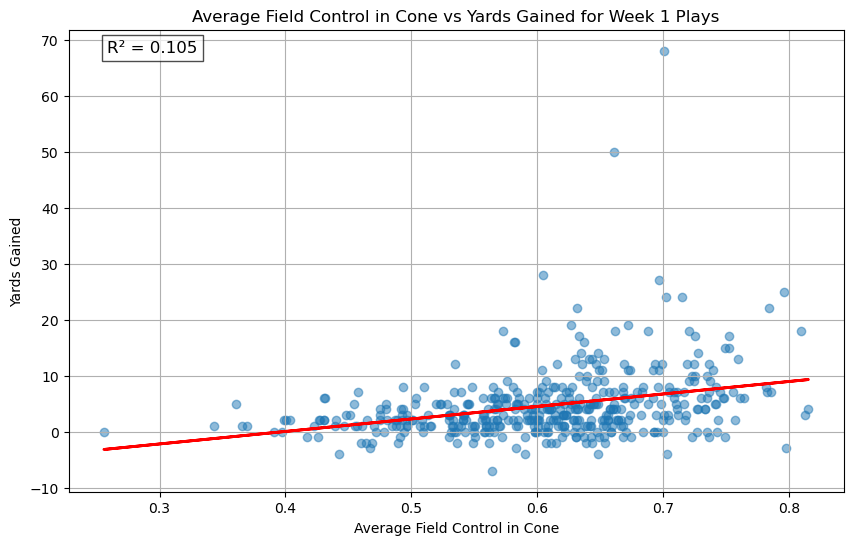

In [ ]:
# plot the relationship
import matplotlib.pyplot as plt

plays_wk1 = plays.merge(
    pd.DataFrame.from_dict(play_results, orient='index', columns=['avg_field_control_in_cone']),
    left_on='game_play_id',
    right_index=True,
    how='left'
).dropna(subset=['avg_field_control_in_cone'])

x = 'avg_field_control_in_cone'

plt.figure(figsize=(10, 6))
plt.scatter(plays_wk1[x], plays_wk1['yards_gained'], alpha=0.5)
# best fit line
m, b = np.polyfit(plays_wk1[x], plays_wk1['yards_gained'], 1)
plt.plot(plays_wk1[x], m * plays_wk1[x] + b, color='red', linewidth=2, label='Best Fit Line')
# plot r squared
r2  v
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('Average Field Control in Cone vs Yards Gained for Week 1 Plays')
plt.xlabel('Average Field Control in Cone')
plt.ylabel('Yards Gained')
plt.grid()
plt.show()

In [33]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(plays_wk1['avg_field_control_in_cone'], plays_wk1['yards_gained'])
print(f"p-value: {p_value:.9f}")

p-value: 0.000000000


# 6. Use the leave-one-out approach for O-Line Attribution 

# NOTE: this takes a long time to run
Took 6 hrs to run on my Macbook Air. You can also load the output data in one of the successive notebook cells from `oline_attribution_results.csv`

In [35]:
import numpy as np
from matplotlib.path import Path
from tqdm import tqdm

def calculate_oline_attribution(game_play_id, cone_granularity=0.5):
    """Calculate O-line attribution using leave-one-out approach"""
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    
    # Get O-line players (assuming position_by_loc identifies them)
    oline = df_all[df_all['position_by_loc'].isin(['LG','LT','C','RG','RT'])].copy()
    if len(oline) < 5:
        return None  # Skip plays with missing O-line data
    
    oline_ids = oline['nfl_id'].unique()
    
    # Calculate baseline (all O-line present)
    baseline_fc = calculate_play_fc(df_all, frame_ids, cone_granularity)
    
    # Calculate leave-one-out scenarios
    results = {}
    for excluded_id in oline_ids:
        modified_df = df_all[df_all['nfl_id'] != excluded_id]
        loo_fc = calculate_play_fc(modified_df, frame_ids, cone_granularity)
        results[excluded_id] = baseline_fc - loo_fc  # Positive = worse without this player
    
    return {
        'game_play_id': game_play_id,
        'baseline_fc': baseline_fc,
        'attributions': results,
        'oline_positions': dict(zip(oline_ids, oline.groupby('nfl_id')['position_by_loc'].first()))
    }

def calculate_play_fc(df, frame_ids, cone_granularity):
    """Helper function to calculate field control for a modified dataframe"""
    fc_values = []
    
    for frame_id in frame_ids:
        frame_df = df[df['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            rb_pos = np.array([rb.x, rb.y])
            rb_dir_rad = rb.dir * np.pi / 180
            rb_speed = rb.s
            
            cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
            path = Path(cone_vertices)
            
            # Create high-resolution grid for cone area
            x_min, x_max = cone_vertices[:,0].min()-2, cone_vertices[:,0].max()+2
            y_min, y_max = cone_vertices[:,1].min()-2, cone_vertices[:,1].max()+2
            
            X, Y, coords = create_cone_grid(x_min, x_max, y_min, y_max, cone_granularity)
            cone_coords = coords[path.contains_points(coords)]
            
            if len(cone_coords) > 0:
                fc = calculate_frame_fc(frame_df, cone_coords)
                fc_values.append(fc)
    
    return np.mean(fc_values) if fc_values else 0

def calculate_frame_fc(frame_df, cone_coords):
    """Calculate field control for a single frame"""
    fc_values = np.zeros(len(cone_coords))
    cols = ['x','y','s','dir','offense','euclidean_dist_to_ball_carrier','engaged',
            'x_closest_off_player','y_closest_off_player']
    
    for i, coord in enumerate(cone_coords):
        for row in frame_df[cols].itertuples(index=False):
            fc_values[i] += influence(
                p=coord,
                p_i=np.array([row.x, row.y]),
                s=row.s + sys.float_info.epsilon,
                theta=row.dir * np.pi / 180,
                rb_dist=row.euclidean_dist_to_ball_carrier,
                is_offense=row.offense
            )
    
    return np.mean(1 / (1 + np.exp(-fc_values)))

def create_cone_grid(x_min, x_max, y_min, y_max, granularity):
    """Create coordinate grid for cone area"""
    X = np.arange(x_min, x_max + granularity, granularity)
    Y = np.arange(y_min, y_max + granularity, granularity)
    X, Y = np.meshgrid(X, Y)
    coords = np.column_stack([X.ravel(), Y.ravel()])
    return X, Y, coords

# Process all plays and save results
attribution_results = []
for game_play_id in tqdm(tracking['game_play_id'].unique(), 
                         desc='Evaluating O-line Attribution'):
    result = calculate_oline_attribution(game_play_id)
    if result:  # Only include plays with complete O-line
        attribution_results.append(result)

# Convert to DataFrame for analysis
attrib_df = pd.DataFrame([
    {
        'game_play_id': res['game_play_id'],
        'player_id': pid,
        'position': res['oline_positions'][pid],
        'fc_attribution': val,
        'baseline_fc': res['baseline_fc']
    }
    for res in attribution_results
    for pid, val in res['attributions'].items()
])

Evaluating O-line Attribution: 100%|██████████| 3623/3623 [6:02:14<00:00,  6.00s/it]  


In [37]:
attrib_df.to_csv('oline_attribution_results.csv', index=False)

In [24]:
attrib_df = pd.read_csv('oline_attribution_results.csv')

In [25]:
attrib_df.head()

,game_play_id,player_id,position,fc_attribution,baseline_fc
0,2022091200_64,41310.0,RG,0.064242,0.55749
1,2022091200_64,43537.0,C,0.017661,0.55749
2,2022091200_64,47907.0,LG,0.014740,0.55749
3,2022091200_64,54474.0,LT,0.000685,0.55749
4,2022091200_64,54537.0,RT,0.021895,0.55749


In [26]:
ol_attrib = (
    attrib_df.merge(
        players[['nfl_id', 'display_name','position']],
        left_on='player_id',
        right_on='nfl_id',
        how='left',
        suffixes=('', '_roster')
    ).groupby('player_id').aggregate({
        'display_name': 'first',
        'position_roster': 'first',
        'fc_attribution': 'mean',
        'position': 'count',
    }).reset_index().sort_values('fc_attribution', ascending=False).rename(columns={
        'position': 'n_plays',
    }).query('n_plays > 80').reset_index(drop=True)
)

ol_attrib.head()

,player_id,display_name,position_roster,fc_attribution,n_plays
0,37266.0,Jason Kelce,C,0.071217,89
1,44870.0,Ethan Pocic,C,0.070674,157
2,52590.0,Michael Onwenu,G,0.070294,128
3,43307.0,Ryan Kelly,C,0.070024,109
4,53466.0,Landon Dickerson,G,0.069889,85


In [27]:
ol_attrib.fc_attribution.describe()

count    119.000000
mean       0.055023
std        0.008221
min        0.037702
25%        0.049169
50%        0.054207
75%        0.061030
max        0.071217
Name: fc_attribution, dtype: float64

In [28]:
ol_attrib = (
    ol_attrib.assign(
        fc_attribution_rescaled=lambda x: (
            x.fc_attribution - x.fc_attribution.min() + 0.005
        ) / (x.fc_attribution.max() - x.fc_attribution.min() + 0.005) *.98
    )
)

# 7. Validate results with all pro history

In [29]:
import nfl_data_py as nfl

cols = ['season','pfr_player_name','category','position','allpro','seasons_started','w_av','games']
allpros = (
    nfl.import_draft_picks(years=range(2000,2023))
    .query('category == "OL"')
    [cols]
    .merge(
        nfl.import_seasonal_rosters([2022])
        .query('position == "OL"')
        [['player_name','rookie_year','gsis_it_id','headshot_url']],
        left_on=['pfr_player_name', 'season'],
        right_on=['player_name', 'rookie_year'],
        how='left'
    )
    .assign(
        gsis_it_id=lambda x: x['gsis_it_id'].astype('float'),
    )
)

allpros.head()

,season,pfr_player_name,category,position,allpro,seasons_started,w_av,games,player_name,rookie_year,gsis_it_id,headshot_url
0,2000,Chris Samuels,OL,T,0.0,9.0,63.0,141.0,NaN,NaN,NaN,NaN
1,2000,Stockar McDougle,OL,T,0.0,3.0,23.0,81.0,NaN,NaN,NaN,NaN
2,2000,Chris McIntosh,OL,T,0.0,1.0,8.0,24.0,NaN,NaN,NaN,NaN
3,2000,Travis Claridge,OL,G,0.0,3.0,23.0,52.0,NaN,NaN,NaN,NaN
4,2000,Marvel Smith,OL,T,0.0,7.0,44.0,111.0,NaN,NaN,NaN,NaN


#### Impute the missing performance data

In [30]:
player_data = {
    "Shaquille Mason": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 67,
        "games": 147
    },
    "Nate Herbig": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 13,
        "games": 61
    },
    "David Andrews": {
        "allpro": 0,
        "seasons_started": 9,
        "w_av": 58,
        "games": 124
    },
    "Evan Brown": {
        "allpro": 0,
        "seasons_started": 6,
        "w_av": 23,
        "games": 74
    },
    "Andrew Norwell": {
        "allpro": 1,
        "seasons_started": 9,
        "w_av": 63,
        "games": 128
    },
    "Matt Feiler": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 47,
        "games": 91
    },
    "Aaron Brewer": {
        "allpro": 0,
        "seasons_started": 3,
        "w_av": 15,
        "games": 75
    },
    "Elijah Wilkinson": {
        "allpro": 0,
        "seasons_started": 6,
        "w_av": 27,
        "games": 79
    },
    "La'el Collins": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 52,
        "games": 89
    },
    "Terence Steele": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 28,
        "games": 79
    },
    "Lloyd Cushenberry": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 22,
        "games": 65
    },
    "Sam Mustipher": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 18,
        "games": 64
    },
    "Alaric Jackson": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 12,
        "games": 41
    },
    "Jon Runyan": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 34,
        "games": 80
    },
    "Charles Leno": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 69,
        "games": 149
    },
    "Jake Brendel": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 20,
        "games": 88
    },
    "Jedrick Wills": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 30,
        "games": 58
    },
    "James Hurst": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 55,
        "games": 150
    },
    "Trenton Brown": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 47,
        "games": 103
    }
}
allpro_missing_vals = pd.DataFrame.from_dict(player_data, orient='index').reset_index().rename(columns={
    'index': 'player_name'
})
allpro_missing_vals

,player_name,allpro,seasons_started,w_av,games
0,Shaquille Mason,0,10,67,147
1,Nate Herbig,0,5,13,61
2,David Andrews,0,9,58,124
3,Evan Brown,0,6,23,74
4,Andrew Norwell,1,9,63,128
5,Matt Feiler,0,7,47,91
6,Aaron Brewer,0,3,15,75
7,Elijah Wilkinson,0,6,27,79
8,La'el Collins,0,7,52,89
9,Terence Steele,0,5,28,79


In [31]:
ol_attrib_final = (
    ol_attrib.merge(
        allpros[['gsis_it_id','allpro','seasons_started','w_av','games','headshot_url']],
        left_on='player_id',
        right_on='gsis_it_id',
        how='left',
    )
    .drop(columns=['gsis_it_id'])
    .merge(
        allpro_missing_vals,
        left_on='display_name',
        right_on='player_name',
        how='left',
        suffixes=('', '_missing')
    )
    .assign(
        allpro=lambda x: x['allpro'].fillna(x['allpro_missing']),
        seasons_started=lambda x: x['seasons_started'].fillna(x['seasons_started_missing']),
        w_av=lambda x: x['w_av'].fillna(x['w_av_missing']),
        games=lambda x: x['games'].fillna(x['games_missing'])
    )
    .drop(columns=['allpro_missing', 'seasons_started_missing', 'w_av_missing', 'games_missing','player_name'])
    .assign(
        allpro_rate=lambda x: x['allpro'] / x['seasons_started']
    )
    .assign(
        allpro_rate=lambda x: x['allpro_rate'].fillna(0),
    )
)
ol_attrib_final.head()

,player_id,display_name,position_roster,fc_attribution,n_plays,fc_attribution_rescaled,allpro,seasons_started,w_av,games,headshot_url,allpro_rate
0,37266.0,Jason Kelce,C,0.071217,89,0.980000,6.0,12.0,102.0,193.0,https://static.www.nfl.com/image/private/f_aut...,0.5
1,44870.0,Ethan Pocic,C,0.070674,157,0.966191,0.0,4.0,30.0,101.0,https://static.www.nfl.com/image/private/f_aut...,0.0
2,52590.0,Michael Onwenu,G,0.070294,128,0.956513,0.0,4.0,26.0,81.0,https://static.www.nfl.com/image/private/f_aut...,0.0
3,43307.0,Ryan Kelly,C,0.070024,109,0.949643,0.0,9.0,54.0,121.0,https://static.www.nfl.com/image/private/f_aut...,0.0
4,53466.0,Landon Dickerson,G,0.069889,85,0.946203,0.0,4.0,31.0,63.0,https://static.www.nfl.com/image/private/f_aut...,0.0


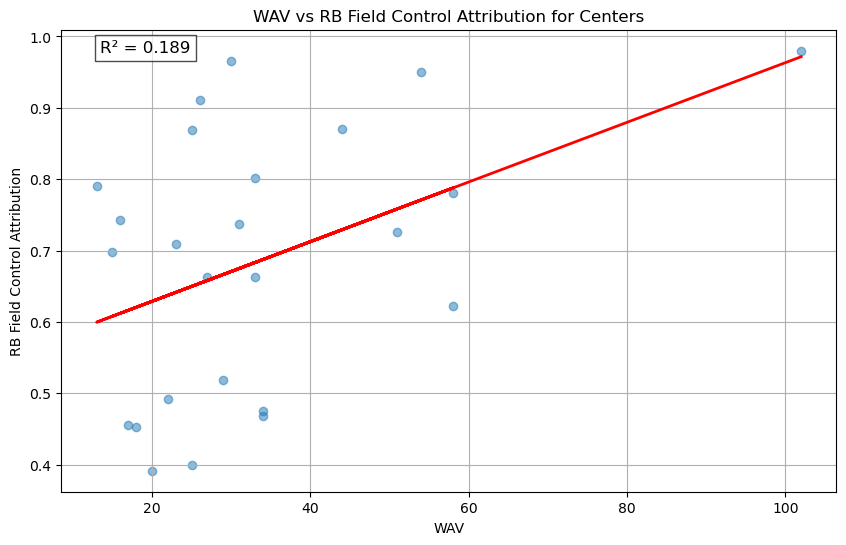

In [32]:
position = 'C'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Centers')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

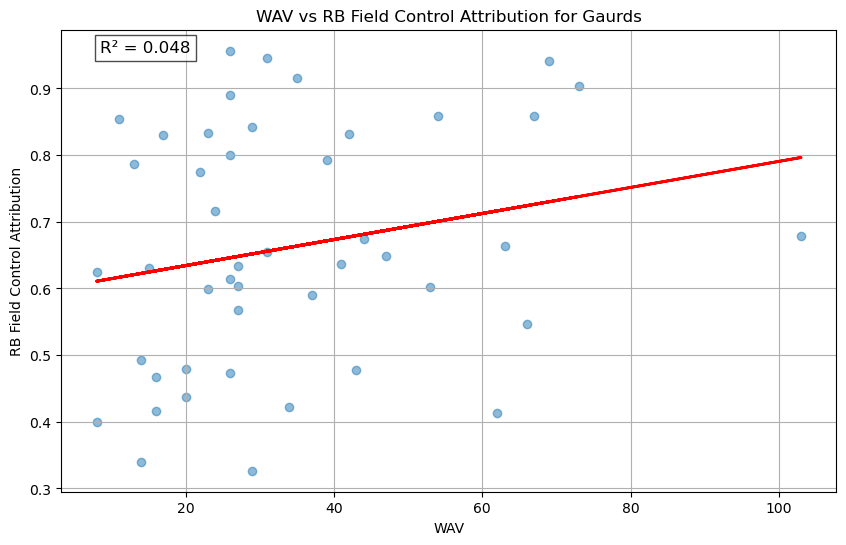

In [33]:
position = 'G'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Gaurds')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

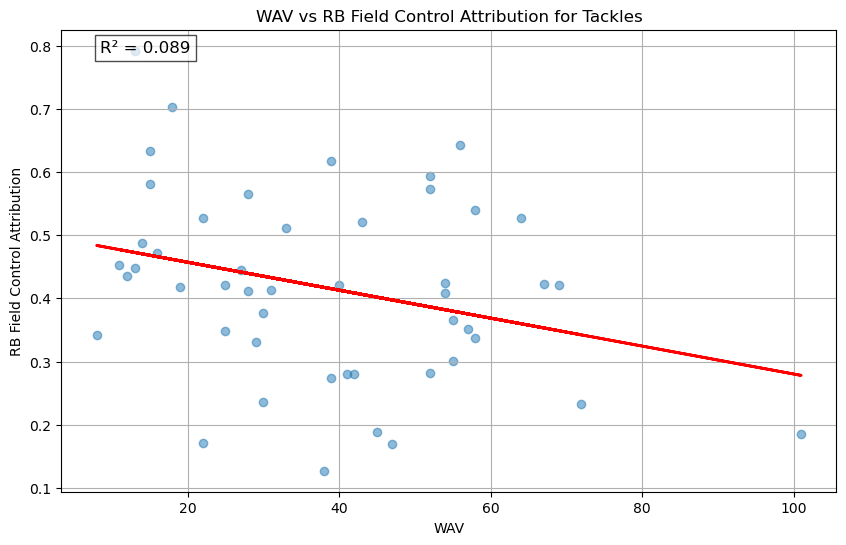

In [34]:
position = 'T'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Tackles')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

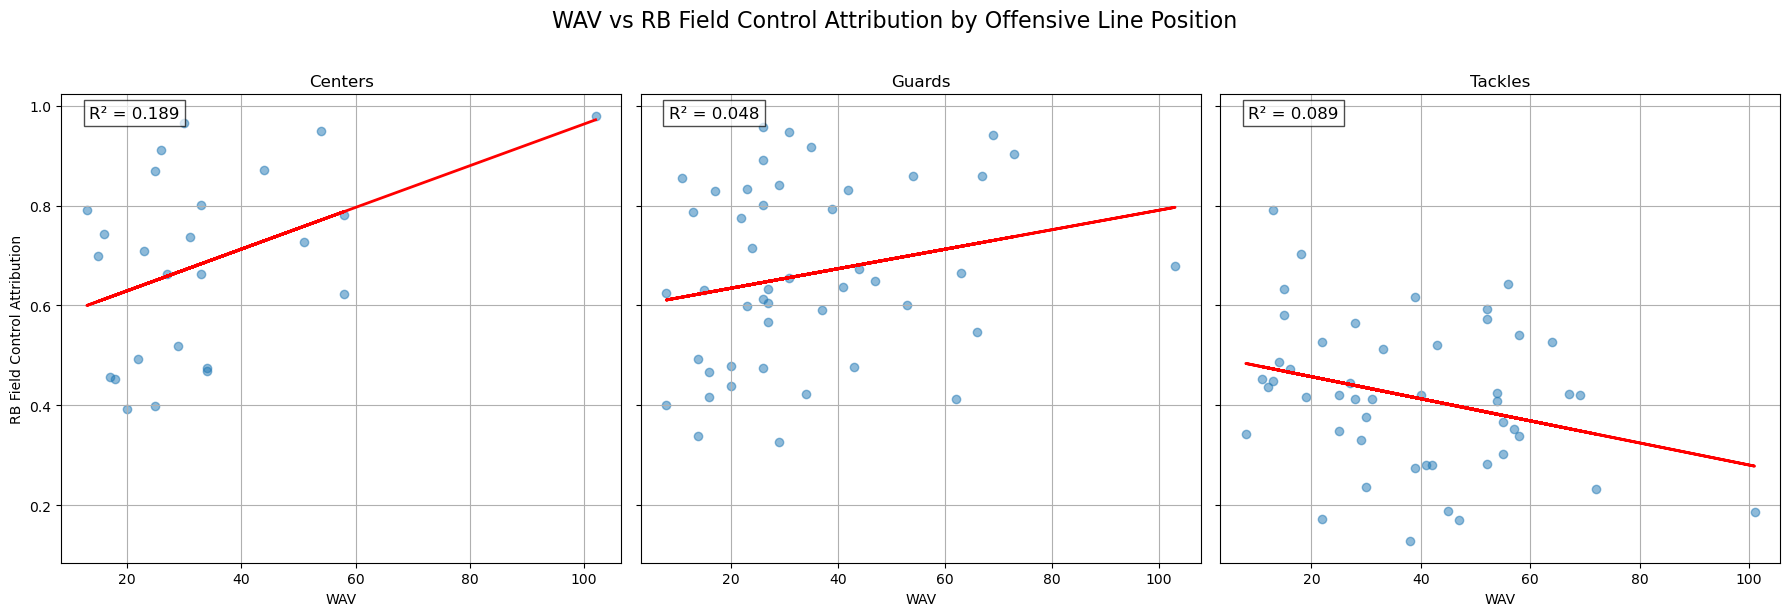

In [35]:
import matplotlib.pyplot as plt
import numpy as np

positions = ['C', 'G', 'T']
position_names = {'C': 'Centers', 'G': 'Guards', 'T': 'Tackles'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, position in zip(axes, positions):
    grouped_attrib = ol_attrib_final.query('position_roster == @position')
    x = grouped_attrib['w_av']
    y = grouped_attrib['fc_attribution_rescaled']
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.5)
    
    # Best fit line
    coeffs = np.polyfit(x, y, 1)
    fit_line = np.poly1d(coeffs)(x)
    ax.plot(x, fit_line, color='red', linewidth=2, label='Best Fit Line')
    
    # R² calculation
    r2 = np.corrcoef(x, y)[0, 1] ** 2
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(position_names[position])
    ax.set_xlabel('WAV')
    if position == 'C':
        ax.set_ylabel('RB Field Control Attribution')
    ax.grid(True)

fig.suptitle('WAV vs RB Field Control Attribution by Offensive Line Position', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# 8. Save the data

In [281]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
(
    ol_attrib_final.query('position_roster == "C"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
).to_csv('center_attribution.csv', index=False)

In [282]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
(
    ol_attrib_final.query('position_roster == "G"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
).to_csv('gaurd_attribution.csv', index=False)

In [283]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
(
    ol_attrib_final.query('position_roster == "T"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
).to_csv('tackle_attribution.csv', index=False)